# Importing Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from matplotlib.dates import MonthLocator, DateFormatter
from dataclasses import dataclass
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score
import os

# Importing data

In [2]:
path = '1. Preprocessing/'
df = pd.read_csv(path + 'Preprocessed_df.csv' , parse_dates=['Date'])
tf.random.set_seed(3) 

cols_dtype = df.columns.drop('Date')
df[cols_dtype] = df[cols_dtype].astype(int)

print(df.shape)
df.head()

(533, 7)


,Date,ActiveCustomer,Churned,DealsAdded,Leads,NewPaid,ClosedDeals
0,2022-03-21,1183,0,3565,19,1,1196
1,2022-03-22,1097,2,774,20,1,478
2,2022-03-23,946,0,997,12,1,458
3,2022-03-24,918,0,590,19,0,370
4,2022-03-25,857,5,498,17,0,282


# Multivariate

In [3]:
# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    WINDOW_SIZE = 50 # values such as 60 and 90 should be checked
    BATCH_SIZE = 32 # other values should be checked
    SHUFFLE_BUFFER_SIZE = 1000

In [4]:
split_train = round(0.6*df.shape[0])
split_val = round(0.8*df.shape[0])

time_train = df.loc[:split_train , 'Date']
time_val = df.loc[split_train+1:split_val , 'Date']
time_test = df.loc[split_val+1: , 'Date']

In [5]:
df_for_training = df.iloc[0:split_train].set_index('Date')
df_for_validation = df.iloc[split_train - G.WINDOW_SIZE + 1:split_val].set_index('Date')
df_for_test = df.iloc[split_val - G.WINDOW_SIZE + 1:].set_index('Date')

In [6]:
scaler = MinMaxScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_validation_scaled = scaler.transform(df_for_validation)
df_for_testing_scaled= scaler.transform(df_for_test)

In [7]:
index_of_ActiveCustomer = list(df_for_training.columns).index('ActiveCustomer')

In [8]:
def createXY(dataset,seq):
    dataX = []
    dataY = []
    for i in range(seq, len(dataset)):
            dataX.append(dataset[i - seq:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,index_of_ActiveCustomer])
    return np.array(dataX),np.array(dataY)  

x_train_mv , y_train_mv = createXY(df_for_training_scaled,G.WINDOW_SIZE)
x_val_mv , y_val_mv = createXY(df_for_validation_scaled,G.WINDOW_SIZE)
x_test_mv , y_test_mv = createXY(df_for_testing_scaled,G.WINDOW_SIZE)

In [9]:
def build_model():
    
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(filters=70, kernel_size=7,
                        strides=1,
                        activation="relu",
                        padding='causal',
                        input_shape=[G.WINDOW_SIZE, 6]),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
            tf.keras.layers.Dropout(0.01),
            tf.keras.layers.Dense(16 , activation = 'relu'),
            # tf.keras.layers.Dense(10 , activation = 'relu'),
            tf.keras.layers.Dense(1 , activation = 'linear'),
        ])

    model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    
    return model

In [10]:
# Build and compile the model
best_model = build_model()

save_path_MV_ConvLSTM = '3. Multivariate Models/ConvLSTM'
os.makedirs(save_path_MV_ConvLSTM ,  exist_ok = True)

checkpoint_callback = ModelCheckpoint(save_path_MV_ConvLSTM+"/model_weights_epoch_{epoch:03d}.h5", save_weights_only=True, save_freq=1)

# Train the model
history = best_model.fit(x_train_mv, y_train_mv, epochs=100, batch_size=G.BATCH_SIZE, verbose=1, validation_data=(x_val_mv, y_val_mv),
                         callbacks=[checkpoint_callback])

Epoch 1/100
10/10 [==============================] - 9s 224ms/step - loss: 0.2466 - val_loss: 0.3154
Epoch 2/100
10/10 [==============================] - 0s 25ms/step - loss: 0.1086 - val_loss: 0.0221
Epoch 3/100
10/10 [==============================] - 0s 25ms/step - loss: 0.0226 - val_loss: 0.0241
Epoch 4/100
10/10 [==============================] - 0s 34ms/step - loss: 0.0136 - val_loss: 0.0271
Epoch 5/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0084 - val_loss: 0.0076
Epoch 6/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0065 - val_loss: 0.0189
Epoch 7/100
10/10 [==============================] - 0s 25ms/step - loss: 0.0064 - val_loss: 0.0074
Epoch 8/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0050 - val_loss: 0.0092
Epoch 9/100
10/10 [==============================] - 0s 25ms/step - loss: 0.0041 - val_loss: 0.0069
Epoch 10/100
10/10 [==============================] - 0s 25ms/step - loss: 0.0031 - val_loss: 0.004

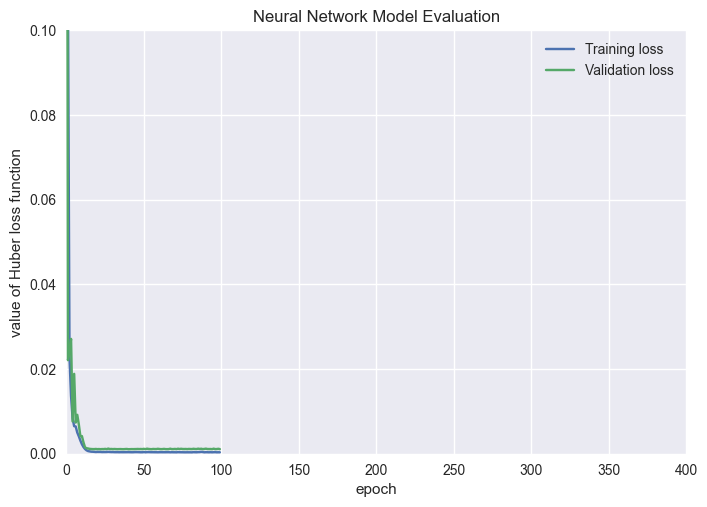

In [11]:
plt.style.use('seaborn')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Neural Network Model Evaluation')
plt.xlabel('epoch')
plt.ylabel('value of Huber loss function')
plt.xlim(0, 400)  
plt.ylim(0, 0.1)  
plt.legend()
plt.show()

In [12]:
def predictions_using_model(model , X , Y , scaler = scaler):
    
    prediction = model.predict(X)
    prediction_copies_array = np.repeat(prediction,6, axis=-1)
    pred = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),6)))[:,0]

    original_copies_array = np.repeat(Y,6, axis=-1)
    original=scaler.inverse_transform(np.reshape(original_copies_array,(len(Y),6)))[:,0]
    return original , pred

In [13]:
x_train_org , x_train_pred = predictions_using_model(best_model , x_train_mv , y_train_mv)
x_val_org , x_val_pred = predictions_using_model(best_model , x_val_mv , y_val_mv)
x_test_org , x_test_pred = predictions_using_model(best_model , x_test_mv , y_test_mv)

In [14]:
list_print = ['Train', 'Val' , 'Test']
x_orgs = [x_train_org , x_val_org , x_test_org]
x_preds = [x_train_pred , x_val_pred , x_test_pred]
for i in range(len(list_print)):
    print(list_print[i])
    
    mse = mean_squared_error(x_orgs[i], x_preds[i])
    mae = mean_absolute_error(x_orgs[i], x_preds[i])
    r2 = r2_score(x_orgs[i], x_preds[i])
    print("MSE: {:.2f}".format(mse))
    print("MAE: {:.2f}".format(mae))
    print("R-squared: {:.2f}".format(r2))
    print()

Train
MSE: 544.71
MAE: 13.11
R-squared: 0.98

Val
MSE: 1860.53
MAE: 21.52
R-squared: 0.91

Test
MSE: 526.75
MAE: 16.37
R-squared: 0.89



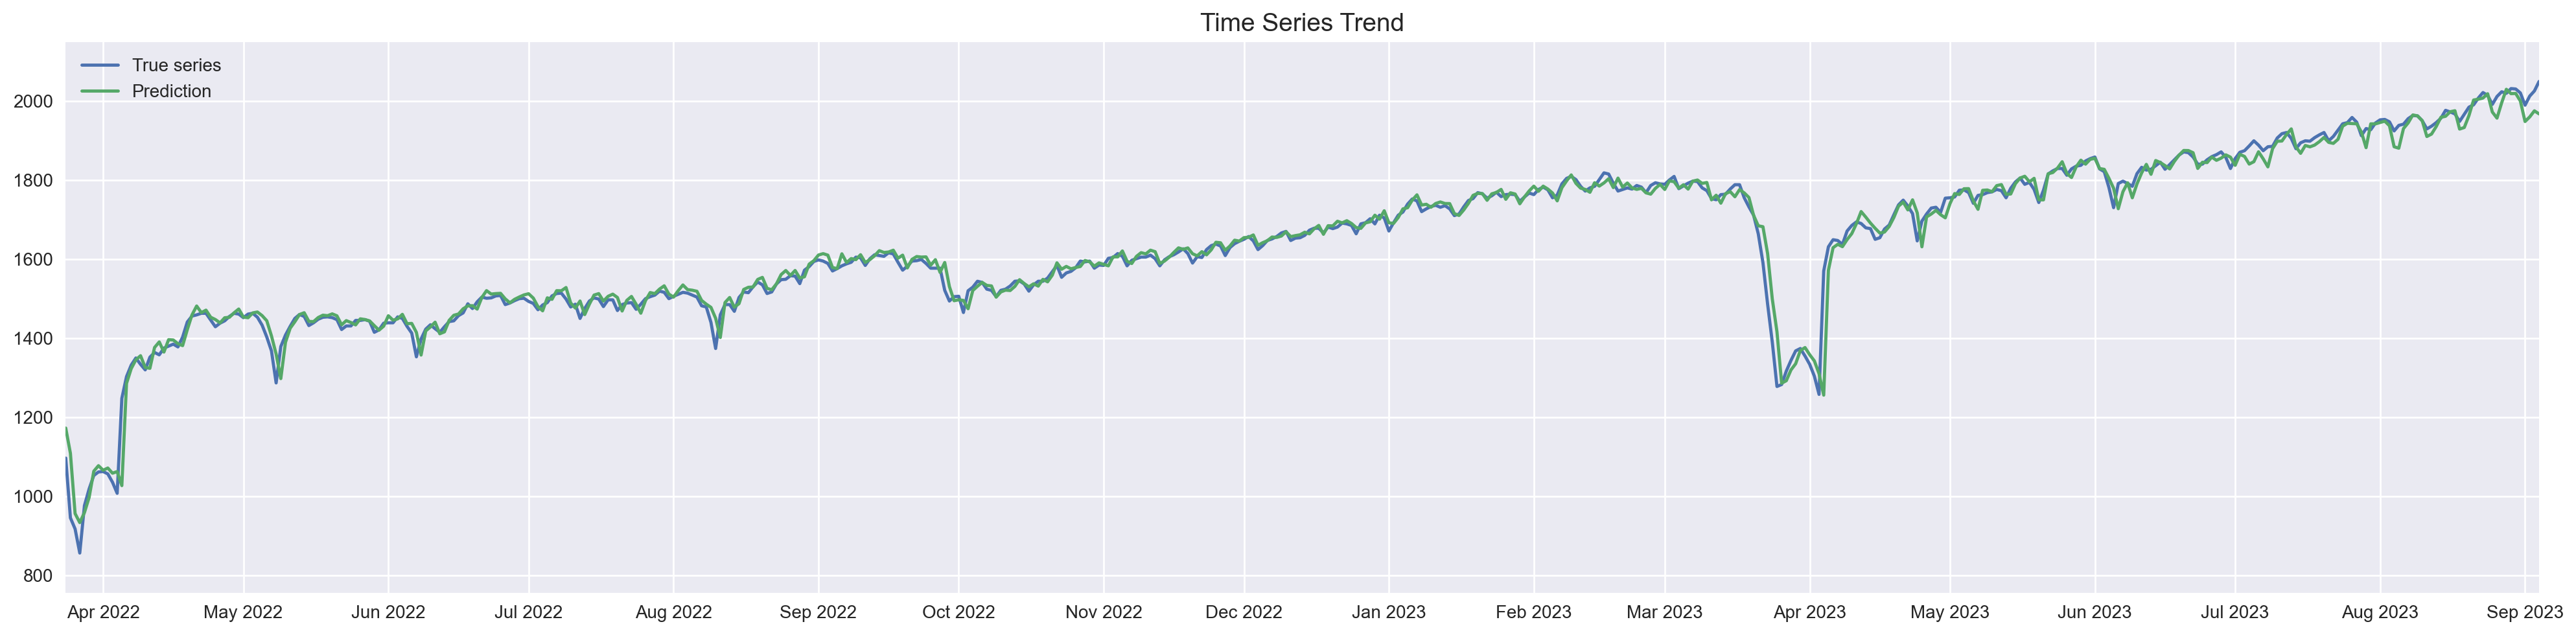

In [15]:
whole_dataset_prediction = np.concatenate(x_preds)
whole_dataset_original = np.concatenate(x_orgs)

plt.figure(figsize=(20, 5), dpi=200)
min_y = whole_dataset_original.min()
max_y = whole_dataset_original.max()

dates = df['Date'][3:]

plt.plot(dates , whole_dataset_original , label = 'True series')
plt.plot(dates , whole_dataset_prediction , label = 'Prediction')

plt.title(f'Time Series Trend', fontsize=14)
plt.tick_params(axis='both', labelsize=10)
plt.xlim([dates.min(), dates.max()])  # Specify the x-axis limits
plt.ylim([min_y-100 , max_y+100])  # Set the y-axis limit to the desired value
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))  # Format the month and year
plt.legend()  # Add legend for series labels
plt.tight_layout()
plt.show()

# Prediction for the 3 months ahead

In [16]:
df.set_index('Date' , inplace=True)
df.head()

,ActiveCustomer,Churned,DealsAdded,Leads,NewPaid,ClosedDeals
Date,,,,,,
2022-03-21,1183,0,3565,19,1,1196
2022-03-22,1097,2,774,20,1,478
2022-03-23,946,0,997,12,1,458
2022-03-24,918,0,590,19,0,370
2022-03-25,857,5,498,17,0,282


In [17]:
X_train_scaled = scaler.transform(df)

In [34]:
def build_model():
    
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(filters=70, kernel_size=7,
                        strides=1,
                        activation="relu",
                        padding='causal',
                        input_shape=[G.WINDOW_SIZE, 6]),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
            tf.keras.layers.Dropout(0.07),
            tf.keras.layers.Dense(8 , activation = 'relu'),
            # tf.keras.layers.Dense(10 , activation = 'relu'),
            tf.keras.layers.Dense(1 , activation = 'linear'),
        ])

    model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    
    return model

In [35]:
# Create X and y 
x_train_mv_final, y_train_mv_final = createXY(X_train_scaled, G.WINDOW_SIZE)

# Build and train model on full dataset
model = build_model()
model.fit(x_train_mv_final, y_train_mv_final, epochs=300, batch_size=G.BATCH_SIZE)

Epoch 1/300
17/17 [==============================] - 8s 12ms/step - loss: 0.2800
Epoch 2/300
17/17 [==============================] - 0s 15ms/step - loss: 0.0292
Epoch 3/300
17/17 [==============================] - 0s 11ms/step - loss: 0.0123
Epoch 4/300
17/17 [==============================] - 0s 12ms/step - loss: 0.0088
Epoch 5/300
17/17 [==============================] - 0s 11ms/step - loss: 0.0055
Epoch 6/300
17/17 [==============================] - 0s 11ms/step - loss: 0.0032
Epoch 7/300
17/17 [==============================] - 0s 12ms/step - loss: 0.0015
Epoch 8/300
17/17 [==============================] - 0s 11ms/step - loss: 9.3735e-04
Epoch 9/300
17/17 [==============================] - 0s 13ms/step - loss: 9.3998e-04
Epoch 10/300
17/17 [==============================] - 0s 11ms/step - loss: 9.0796e-04
Epoch 11/300
17/17 [==============================] - 0s 11ms/step - loss: 7.7069e-04
Epoch 12/300
17/17 [==============================] - 0s 12ms/step - loss: 8.3373e-04
Epoch

In [36]:
# Take the last sequence from the training data
last_sequence = X_train_scaled[-1:]

In [37]:
last_sequence = last_sequence.reshape(1, G.WINDOW_SIZE, 6)

In [38]:
n=90
# Initialize an array to store forecasted values
forecasted_values = []

# Forecast the next 90 values
for _ in range(n):
    # Predict the next value
    next_value = model.predict(last_sequence)
    # Append the predicted value to the forecasted_values array
    forecasted_values.append(next_value)
    # Update the last_sequence by shifting values and adding the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1] = next_value

In [39]:
# Convert the forecasted_values array to numpy array
forecasted_values = np.array(forecasted_values).reshape(-1)
prediction_copies_array = np.repeat(forecasted_values,6, axis=-1)
forecasted_values_original_scale=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(forecasted_values),6)))[:, 0]

In [40]:
forecast = forecasted_values_original_scale
time = df.index.to_numpy()
existing_data = np.repeat(y_train_mv_final,6, axis=-1)
e_data=scaler.inverse_transform(np.reshape(existing_data,(len(y_train_mv_final),6)))[:, 0]

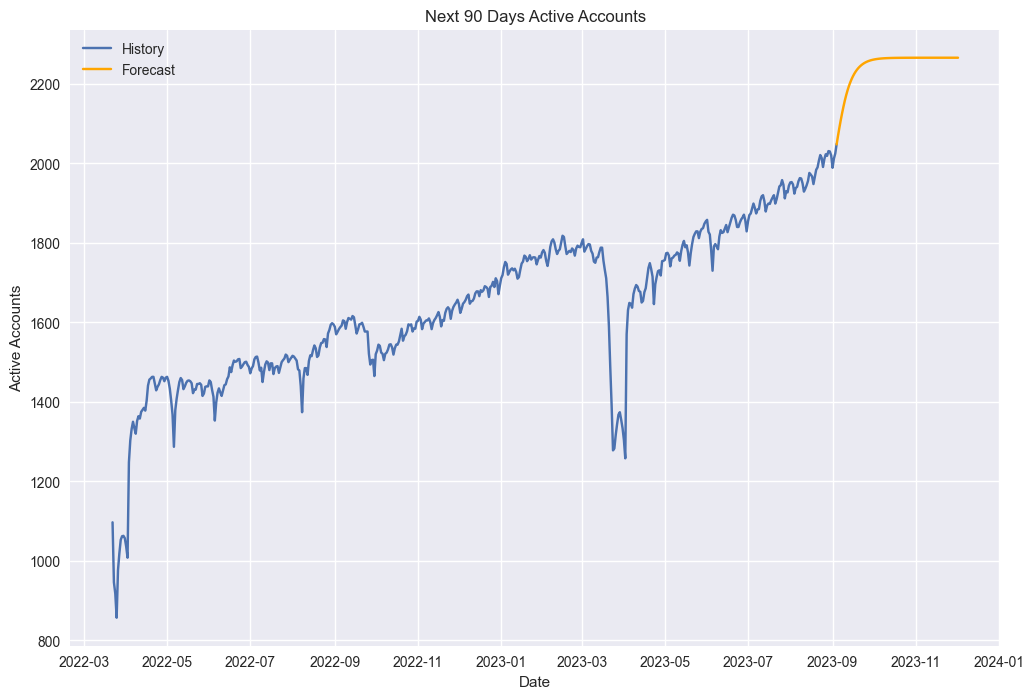

In [41]:
# Add new dates corresponding to the forecasted values
time1 = np.append(time, pd.date_range(start=time[-1], periods=n, freq='D')[1:])

# Plot
fig, ax = plt.subplots(figsize=(12, 8)) 
ax.plot(time[1:], e_data, label='History') 
ax.plot(time1[-n:], forecast, label='Forecast', color='orange')
ax.set(title='Next 90 Days Active Accounts', xlabel='Date', ylabel='Active Accounts')
ax.legend()
plt.show()